In [41]:
from Data.dataset import SlakhTranscriptionDataset
from torch.utils.data import DataLoader
from model import TranscriptionNet
import torch.optim as optim
import torch.nn as nn
import torch

In [42]:
INSTRUMENTS = ['Drums', 'Bass', 'Guitar', 'Piano']
SLAKH_ROOT = 'D:\Ana\Projeler\CS 415\CS-415-Deep-Learning\Data\slakh\dataset'

In [43]:
# 1. Setup Dataset
# Example: Transcribe ONLY the Piano parts from the full audio mix
dataset = SlakhTranscriptionDataset(
    root_dir=SLAKH_ROOT, # Check your path!
    split='train', 
    target_class='All',  # Change to 'Guitar' or 'All' as needed
    sequence_length=128    # Smaller length = Faster training in Jupyter
)

loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)

# 2. Initialize
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TranscriptionNet().to(device) # (Assuming you defined TranscriptionNet earlier)

# 3. Loss (BCE for Multi-label Classification)
# We use pos_weight because 90% of the piano roll is zeros (silence).
# Weighting positive pixels by 10x forces the model to care about notes.
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([10.0]).to(device))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 4. Train
print("Starting Training...")
model.train()

for i, (spec, target) in enumerate(loader):
    spec = spec.to(device)
    target = target.to(device)
    
    # Forward
    preds = model(spec)
    
    # Loss
    loss = criterion(preds, target)
    
    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % 5 == 0:
        print(f"Step {i}: Loss {loss.item():.4f}")
        
    # Stop early for demo
    if i == 20: 
        break

print("Done!")

Starting Training...
Step 0: Loss 0.9413
Step 5: Loss 0.9015
Step 10: Loss 0.9096
Step 15: Loss 0.7161
Step 20: Loss 0.7883
Done!


Dolu bir örnek aranıyor... Bulundu! İndeks: 0
Toplam Nota 'Pikseli' Sayısı: 929.0


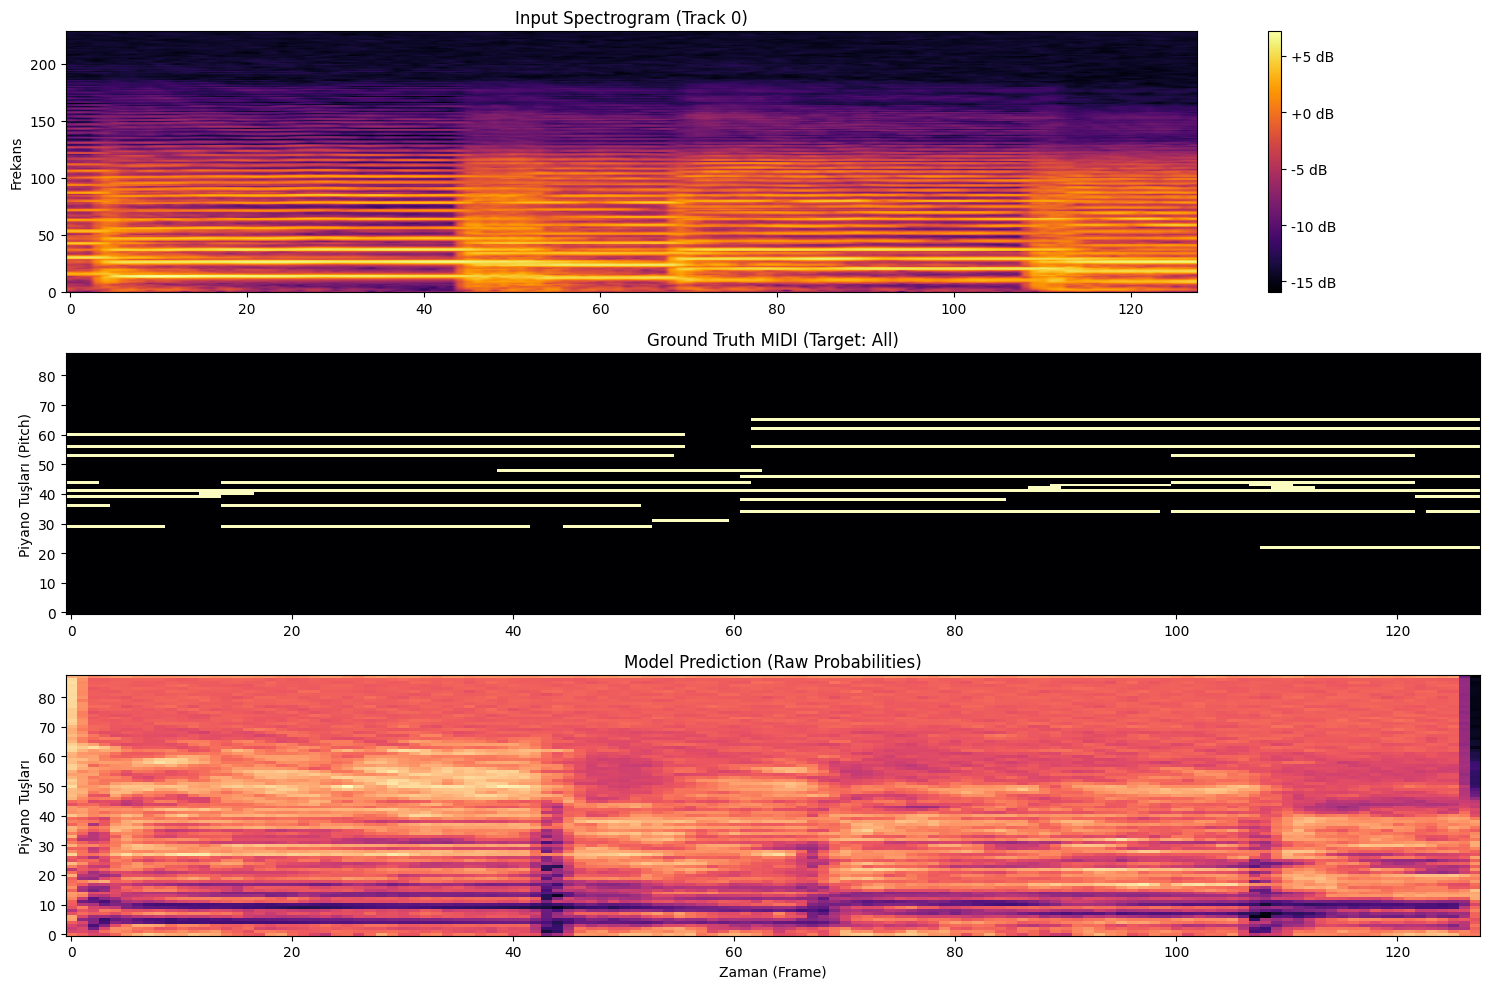

In [44]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# 1. Dolu bir örnek (Non-empty sample) bulana kadar ara
found_idx = -1
spec, target = None, None

print("Dolu bir örnek aranıyor...", end="")
for i in range(len(dataset)):
    s, t = dataset[i] # __getitem__ rastgele crop yapar
    
    # Eğer target tensöründeki notaların toplamı 0'dan büyükse, nota var demektir.
    if t.sum() > 0:
        spec = s
        target = t
        found_idx = i
        print(f" Bulundu! İndeks: {i}")
        print(f"Toplam Nota 'Pikseli' Sayısı: {t.sum().item()}")
        break
    
    if i % 50 == 0: print(".", end="")

if found_idx == -1:
    print("\n❌ HATA: Dataset tamamen boş görünüyor! target_class ayarını veya klasör yolunu kontrol et.")
else:
    # 2. Tahmin Yap (Modeli Kullan)
    model.eval()
    with torch.no_grad():
        # Batch boyutu ekle: [1, 1, 229, T]
        spec_input = spec.unsqueeze(0).to(device)
        
        # Modelden geçir
        logits = model(spec_input)
        pred = torch.sigmoid(logits)

    # 3. Çizim Yap
    plt.figure(figsize=(15, 10))

    # A. Input Spectrogram
    plt.subplot(3, 1, 1)
    plt.imshow(spec[0].cpu().numpy(), origin='lower', aspect='auto', cmap='inferno')
    plt.title(f"Input Spectrogram (Track {found_idx})")
    plt.ylabel("Frekans")
    plt.colorbar(format='%+2.0f dB')

    # B. Ground Truth (Gerçek)
    plt.subplot(3, 1, 2)
    # Sadece 0. kanalı (mono) al
    target_img = target[0].cpu().numpy()
    plt.imshow(target_img, origin='lower', aspect='auto', cmap='magma', interpolation='nearest')
    plt.title(f"Ground Truth MIDI (Target: {dataset.target_class})")
    plt.ylabel("Piyano Tuşları (Pitch)")

    # C. Model Tahmini
    plt.subplot(3, 1, 3)
    pred_img = pred[0, 0].cpu().numpy()
    plt.imshow(pred_img, origin='lower', aspect='auto', cmap='magma', interpolation='nearest')
    plt.title("Model Prediction (Raw Probabilities)")
    plt.xlabel("Zaman (Frame)")
    plt.ylabel("Piyano Tuşları")
    
    plt.tight_layout()
    plt.show()

In [45]:
import pretty_midi
import numpy as np

def piano_roll_to_pretty_midi(piano_roll, fs=100, program=0):
    '''Converts a Piano Roll (88 x Time) matrix back to a PrettyMIDI object'''
    notes, frames = piano_roll.shape
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)

    # pad 1 column of zeros so we can acknowledge ending events
    piano_roll = np.pad(piano_roll, [(0, 0), (1, 1)], 'constant')

    # use changes in value to find note on / note off events
    velocity_changes = np.diff(piano_roll).T
    prev_velocities = np.zeros(notes, dtype=int)
    note_on_time = np.zeros(notes)

    for time, row in enumerate(velocity_changes):
        velocity = row
        # Find indices where note state changed
        change_indices = np.where(velocity != 0)[0]
        
        for note_idx in change_indices:
            if velocity[note_idx] > 0:
                # Note turned ON
                note_on_time[note_idx] = time
            else:
                # Note turned OFF
                # Create the note object
                note_number = note_idx + 21 # Shift back to MIDI pitch (0-87 -> 21-108)
                start_time = note_on_time[note_idx] / fs
                end_time = time / fs
                
                # Create Note (Velocity 100 is standard loud volume)
                note = pretty_midi.Note(velocity=100, pitch=note_number, start=start_time, end=end_time)
                instrument.notes.append(note)

    pm.instruments.append(instrument)
    return pm

🎹 Original (Ground Truth MIDI):



🤖 Model Prediction:


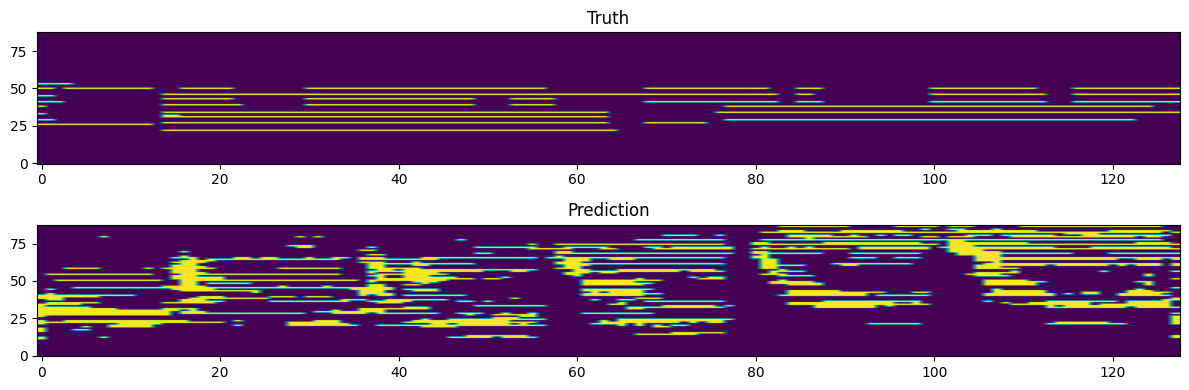

In [ ]:
import IPython.display as ipd

# 1. Get a sample
model.eval()
device = next(model.parameters()).device

# Grab a batch
with torch.no_grad():
    # Assuming your loader returns (spec, target)
    # We fetch one batch and take the first item
    spec, target_roll = next(iter(loader)) 
    
    # Move to GPU for prediction
    spec = spec.to(device)
    
    # Predict [B, 1, 88, T]
    logits = model(spec)
    probabilities = torch.sigmoid(logits)
    
    # Thresholding: Convert probabilities (0.0 to 1.0) to Binary (0 or 1)
    # We use 0.5 as the cutoff
    predicted_roll = (probabilities > 0.5).float()

# --- PREPARE DATA FOR PLAYBACK ---

# A. Original Audio (From Spectrogram reconstruction or raw loading)
# Note: We can't easily invert the MelSpectrogram perfectly, 
# so let's just use the raw mix if you have it. 
# If not, we can try to synthesize the GROUND TRUTH midi to compare.

# Let's use the Ground Truth MIDI as the reference "Original" sound
target_roll_np = target_roll[0, 0].cpu().numpy()
fs = 16000 / 512 # Sample Rate / Hop Length (~31.25 fps)

pm_original = piano_roll_to_pretty_midi(target_roll_np, fs=fs)
audio_original = pm_original.synthesize(fs=16000)

# B. Predicted Audio
pred_roll_np = predicted_roll[0, 0].cpu().numpy()
pm_predicted = piano_roll_to_pretty_midi(pred_roll_np, fs=fs)
audio_predicted = pm_predicted.synthesize(fs=16000)

# --- DISPLAY ---

print("🎹 Original (Ground Truth MIDI):")
ipd.display(ipd.Audio(audio_original, rate=16000))

print("\n🤖 Model Prediction:")
ipd.display(ipd.Audio(audio_predicted, rate=16000))

# Optional: Plot to see why it sounds that way
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(2,1,1); plt.imshow(target_roll_np, aspect='auto', origin='lower'); plt.title("Truth")
plt.subplot(2,1,2); plt.imshow(pred_roll_np, aspect='auto', origin='lower'); plt.title("Prediction")
plt.tight_layout()
plt.show()